## Deploy Mphasis DeepInsights Face Mask Detector Model Package from AWS Marketplace 

Mphasis DeepInsights Face Mask Detector takes images as input, detects faces present and then classifies whether the detected faces are wearing masks or not. This solution can be used by organizations at places such as entry gates, common hall, cafeteria etc. to ensure adherence to public health policies during pandemic times.

This sample notebook shows you how to deploy Mphasis DeepInsights Face Mask Detector using Amazon SageMaker.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to Mphasis DeepInsights Face Mask Detector. If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

#### Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Output Result](#D.-Output-Result)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Perform batch inference](#3.-Perform-batch-inference) 
4. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page Mphasis DeepInsights Face Mask Detector
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

In [5]:
model_package_arn='arn:aws:sagemaker:us-east-2:786796469737:model-package/mphasis-mask-detector-v02-copy-10-21-copy-10-21'

In [6]:
import pandas as pd
import numpy as np
import json
import os
import boto3
from zipfile import ZipFile
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from IPython.display import Image, display

In [7]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket=sagemaker_session.default_bucket()
bucket

'sagemaker-us-east-2-786796469737'

### 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [8]:
model_name='mask-detector-a'

content_type='application/zip'

real_time_inference_instance_type='ml.m5.large'
batch_transform_inference_instance_type='ml.m5.large'

#### A. Create an endpoint

In [9]:
def predict_wrapper(endpoint, session):
    return sage.RealTimePredictor(endpoint, session,content_type=content_type)

#create a deployable model from the model package.

model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

In [ ]:
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

#### Instructions
•	Keep the input images in a folder, zip the folder and provide the zipped folder as input to this algorithm.

•	The input images should be of the format ‘.jpg’, ‘.jpeg’ or ‘.png’ 

•	Folder size should not exceed 15 MB

Image: 0048.jpg


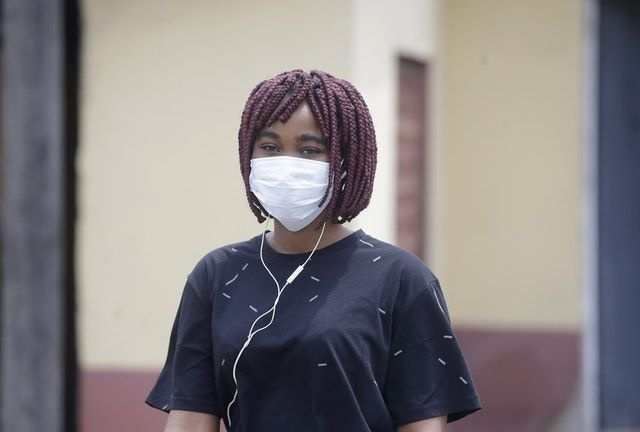


----
Image: 0055.jpg


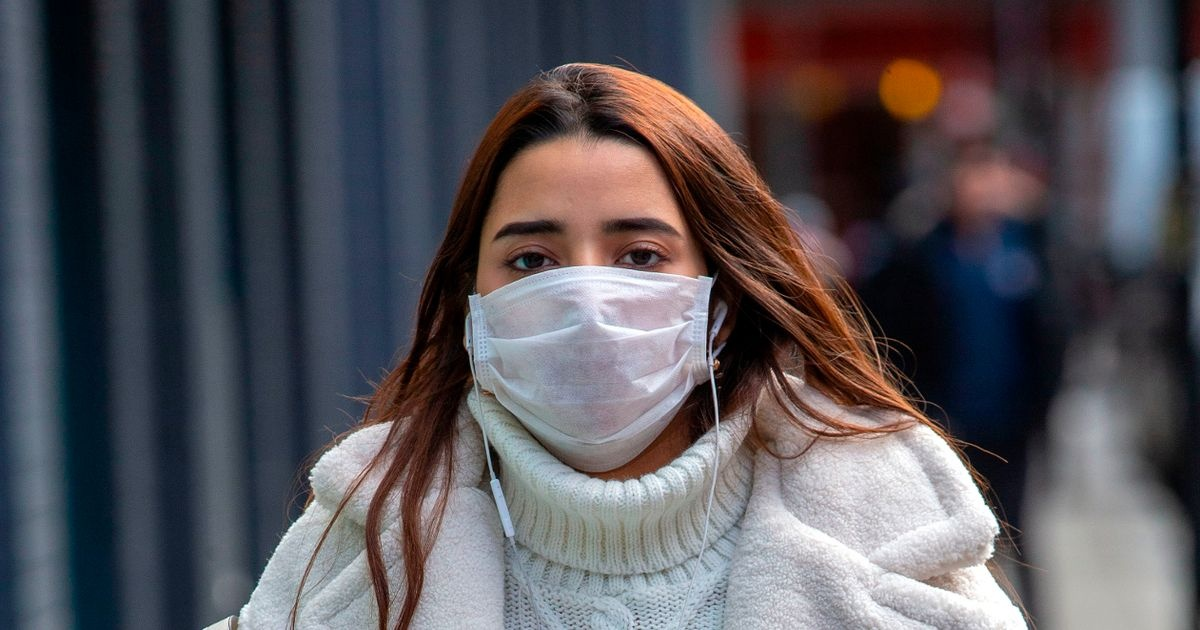

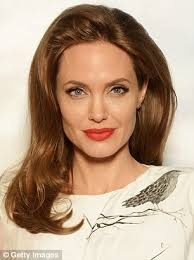

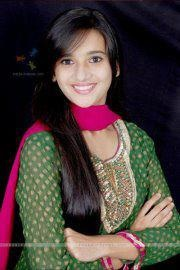


----
Image: 23.jpg

----
Image: 0.jpg

----


In [11]:
file_path = os.getcwd()
file_name = 'data/input/inputs_2.zip'

file_object = open(file_name,'rb')
z = ZipFile(file_object)
file_names = []
for name in z.namelist():
    z.extract(name,file_path)
    file_names.append(name)
file_object.close()
input_folder_path = os.path.join(file_path, "inputs_2") 
images = os.listdir(input_folder_path)

for image in images:
    img_path = os.path.join(input_folder_path, image)
    print("Image:", image)
    display(Image(filename=img_path))
    print("\n----")

#### C. Perform real-time inference

In [12]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name $model_name --body fileb://$file_name --content-type 'application/zip' --region us-east-2 output.zip

{
    "ContentType": "application/zip",
    "InvokedProductionVariant": "AllTraffic"
}


#### D. Output Result

Let us process the output.

Supported Content type: `application/zip`

•	Output will be the zipped folder containing images processed by the algorithm

•	Output images will have detected faces within the box along with ‘Mask’ or ‘No Mask’ confidence

Image: 0048.jpg


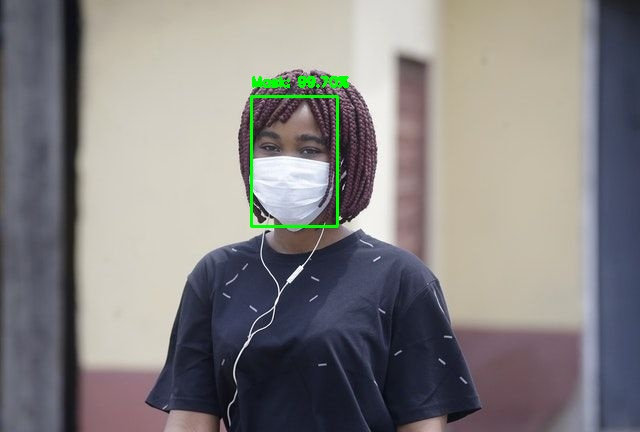


----
Image: 0055.jpg


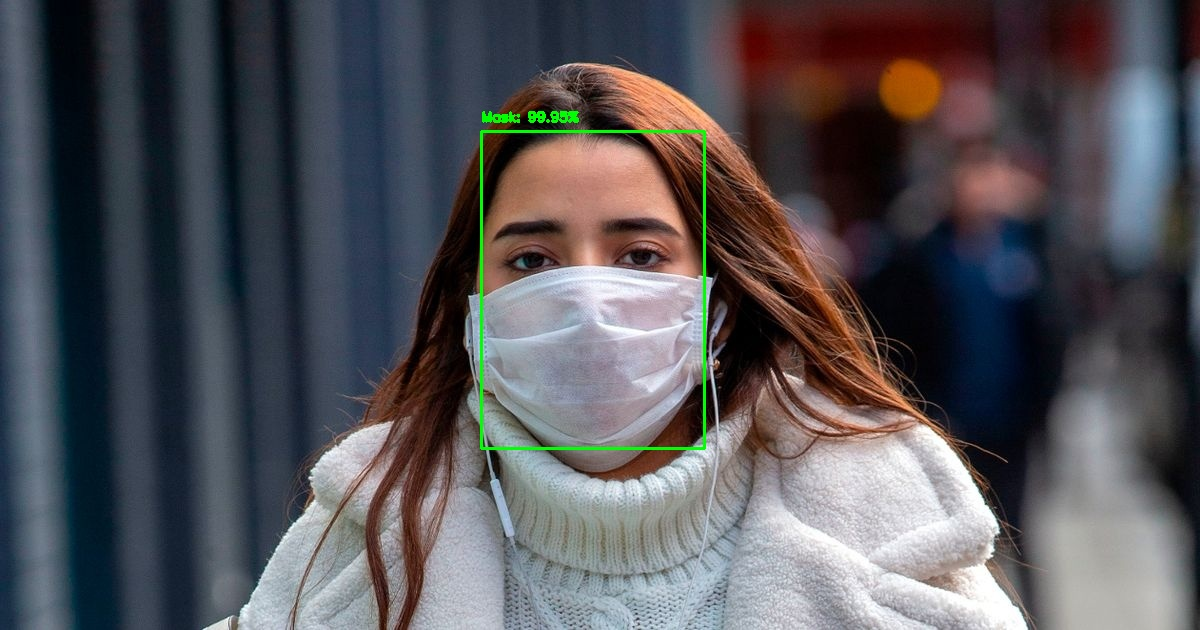


----
Image: 23.jpg


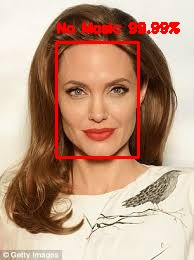


----
Image: 0.jpg


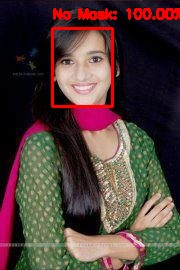


----


In [13]:
file_path = os.getcwd()
file_name = 'data/output/output.zip'

file_object = open(file_name,'rb')
z = ZipFile(file_object)
file_names = []
for name in z.namelist():
    z.extract(name,file_path)
    file_names.append(name)
file_object.close()
output_folder_path = os.path.join(file_path, "output") 
images = os.listdir(output_folder_path)

for image in images:
    img_path = os.path.join(output_folder_path, image)
    print("Image:", image)
    display(Image(filename=img_path))
    print("\n----")

#### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [14]:
predictor=sage.predictor.Predictor(model_name, sagemaker_session,content_type)
predictor.delete_endpoint(delete_endpoint_config=True)

### 3. Perform batch inference

In this section, you will perform batch inference using multiple input payloads together. If you are not familiar with batch transform, and want to learn more, see these links:
1. [How it works](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)
2. [How to run a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html)

In [ ]:
import json 
import uuid


transformer = model.transformer(1, 'ml.m5.large')
transformer.transform('s3://mphasis-marketplace/mask_detector/inputs_2.zip', content_type='application/zip')
transformer.wait()
#transformer.output_path
print("Batch Transform complete")
bucketFolder = transformer.output_path.rsplit('/')[3]

In [16]:
#print(s3bucket,s3prefix)
s3_conn = boto3.client("s3")
bucket_name="sagemaker-us-east-2-786796469737"
with open('output.zip', 'wb') as f:
    s3_conn.download_fileobj(bucket_name, bucketFolder+'/inputs_2.zip.out', f)
    print("Output file loaded from bucket")

Output file loaded from bucket


Image: 0048.jpg


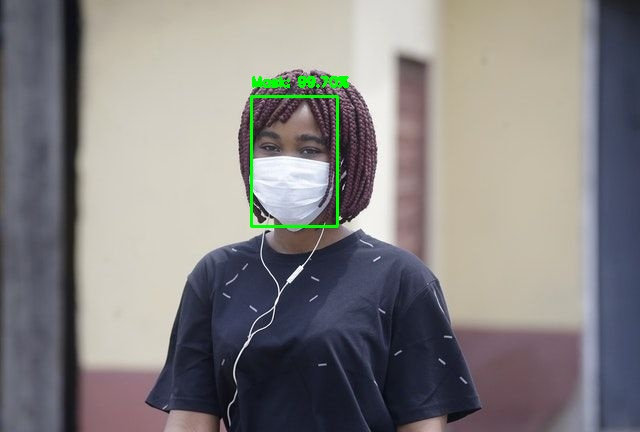


----
Image: 0055.jpg


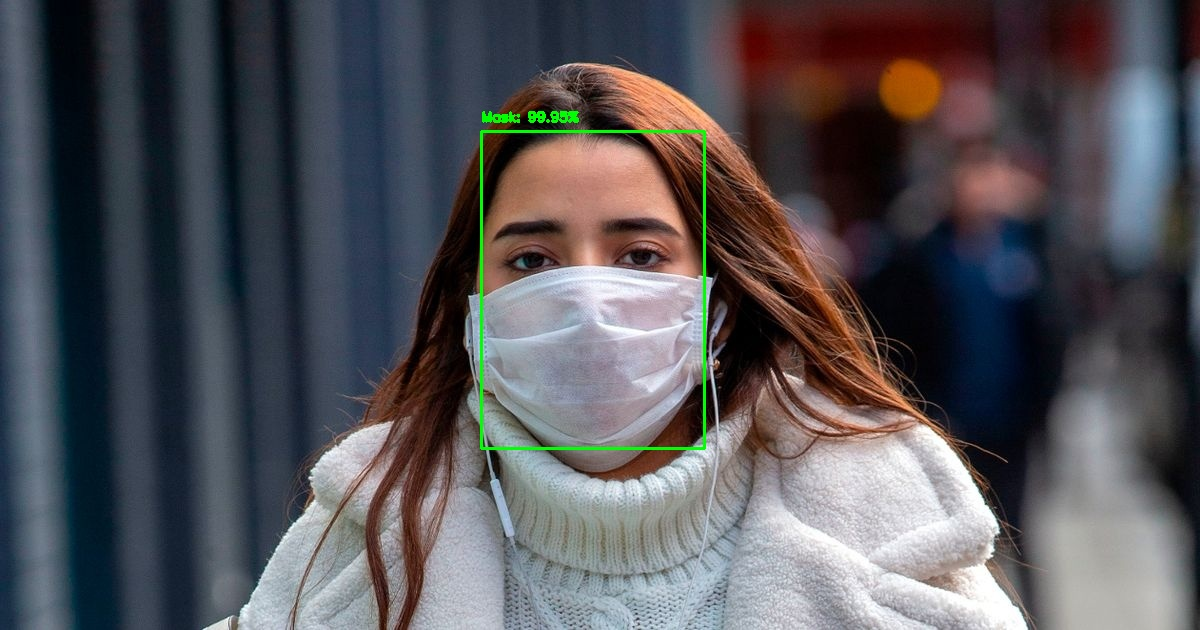


----
Image: 23.jpg


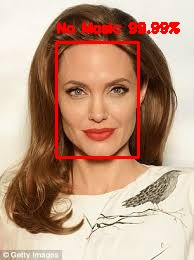


----
Image: 0.jpg


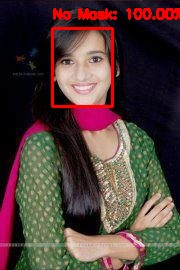


----


In [17]:
file_path = os.getcwd()
file_name = 'data/output/output.zip'

file_object = open(file_name,'rb')
z = ZipFile(file_object)
file_names = []
for name in z.namelist():
    z.extract(name,file_path)
    file_names.append(name)
file_object.close()
output_folder_path = os.path.join(file_path, "output") 
images = os.listdir(output_folder_path)

for image in images:
    img_path = os.path.join(output_folder_path, image)
    print("Image:", image)
    display(Image(filename=img_path))
    print("\n----")

### 4. Clean-up

#### A. Delete the model

In [18]:
model.delete_model()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.